This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/datasets.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [1]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    colab.drive.mount('/content/drive')
    %pip install webdataset python-slugify
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [2]:
import io
import re
import csv
import math
import random
import numpy as np
import pandas as pd
import webdataset as wds  # pip install webdataset

from typing import Optional, Tuple, List, Callable, Type
from tqdm.notebook import tqdm  # pip install tqdm
from inspect import getsource
from slugify import slugify  # pip install python-slugify
from warnings import warn
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = (15, 5)
rcParams["figure.autolayout"] = True

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [3]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Features

Here we prove that the feature extractor implemented (using a [Gammatone
Filterbank](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/gammatone/))
works as expected.


We will use the same audio file as in the [original
implementation](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/)
(A matlab C extension).


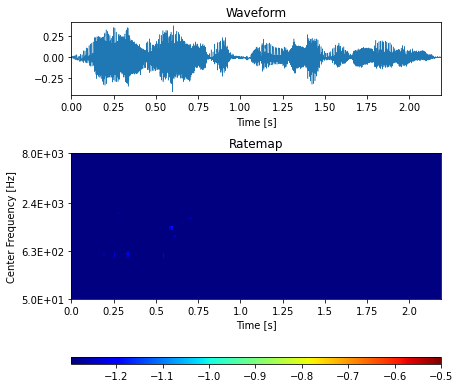

In [4]:
audio_url = (
    r"https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources"
    r"/ratemap/t29_lwwj2n_m17_lgwe7s.wav"
    )
data, sample_rate = ao.io.audio_read(audio_url)
frame_length = 10  # [ms]
frame_samples = int(
    np.ceil(frame_length / 1000 * sample_rate)
    )  # samples per frame
fig, axs = plt.subplots(
    3, 1, figsize=(6.5, 5.5), gridspec_kw={'height_ratios': [0.5, 1, 0.05]}
    )
# Signal
ao.plot.signal(data, sample_rate, ax=axs[0])
axs[0].set_title('Waveform')
# Gammatonegram
frame_length = 10  # [ms]
frame_samples = math.ceil(frame_length / 1000 * sample_rate)
plot, _ = ao.plot.gammatonegram(
    data,
    sample_rate,
    frame_samples,
    num_features=64,
    low_Hz=50,
    high_Hz=8000,
    pcolormesh_kwargs={
        'cmap': 'jet',
        'vmin': -0.5
        },
    ax=axs[1]
    )
axs[1].set_title('Ratemap')
fig.colorbar(plot, cax=axs[2], orientation="horizontal")
fig.tight_layout()

One can see that our implementation corresponds with the example found in the
original implementation.

![Ratemap](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/ratemap.png)


# Wheel Test Bed Experiments


## Experiment 0

In order to gather some data and test our initial hypothesis, we decided to
carry a simple experimetn with a single wheel test bed.


In [5]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_0 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-0"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_0)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT0'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:159: UserWarning: Could not parse VAO_2022-03-08_17-12-37 from VAO_2022-03-08_17-12-37, item VAO_2022-03-08_17-12-37 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))
c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:159: UserWarning: Could not parse VAO_2022-03-08_17-11-21 from VAO_2022-03-08_17-11-21, item VAO_2022-03-08_17-11-21 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))


In [6]:
# TODO show gammatonegram for some recordings

In [7]:
# TODO show gammatonegram for some recordings

In [8]:
def plot_primitive_experiment(audio_file, ax=None):
    data, sample_rate = ao.io.audio_read(audio_file)
    frame_length = 500  # [ms]
    frame_samples = int(
        np.ceil(frame_length / 1000 * sample_rate)
        )  # samples per frame
    return ao.plot.gammatonegram(
        data,
        sample_rate,
        frame_samples,
        num_features=64,
        low_Hz=0,
        high_Hz=22050,
        pcolormesh_kwargs={
            'cmap': 'jet',
            'vmin': -1
            },
        ax=ax
        )

In [9]:
data = pd.DataFrame.from_dict(recordings, orient='index')

In [10]:
# w_data = {}
# for c in data.values():
#     w_data[c['w']] = w_data.get(c['w'], []) + [c]
# fig, axs = plt.subplots(
#     len(w_data), max([len(v) for v in w_data.values()]), figsize=(15, 10)
#     )
# row = -1
# last_w = None
# for folder, experiment in data.items():
#     if last_w != experiment['w']:
#         row += 1
#         col = 0
#     else:
#         col += 1
#     last_w = experiment['w']
#     plot, ax = plot_primitive_experiment(
#         folder / 'audio0crop.wav', ax=axs[row, col]
#         )
#     ax.set_title(
#         ', '.join(
#             f"{k}={experiment[k]} {naming[k].get('unit', '')}"
#             for k in naming.keys()
#             )
#         )
# fig.colorbar(plot, cax=axs[-1, -1])
# fig.tight_layout()

## Experiment 1

In this experiment we improved the sensor setup, synchronization and control
with respect to the [Experiment 0](#experiment-0). This experiment was used to
develop a proof of concept for the Acoustic Odometry.


In [11]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_0 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-1"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_0)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f"Invalid experiment folder {EXPERIMENT_FOLDER}")
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT1'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

In [12]:
sample_recording, recording_parameters = list(recordings.items())[1]


def get_recording_ground_truth(
        recording: Path, wheel_radius: float = 0.1
    ) -> pd.DataFrame:
    """Gets the ground truth of a training recording from its control file

    Args:
        recording (Path): Path to a training recording folder. Its
            corresponding control file must be located in the parent folder
            and have the same name as the recording folder.
        wheel_radius (float, optional): Effective radius of the wheel in [m].

    Returns:
        pd.DataFrame: Ground truth of the recording with columns 'ms', 'X',
            'Vx', 'Vw', 'slip', 'wheel_rotation' and 'timestamp' as index.
    """
    gt = pd.read_csv(
        recording.parent / (recording.name + '.csv'),
        index_col='timestamp',
        usecols=['timestamp', 'ms', 'X', 'Vx', 'Vw', 'wheel_rotation'],
        )
    # Remove the first row from the dataframe, the velocity there is useless
    gt = gt.iloc[1:, :]
    # Compute slip
    gt['Vx_from_encoder'] = gt['Vw'].apply(np.deg2rad) * wheel_radius
    gt['slip'] = (gt['Vx_from_encoder'] -
                  gt['Vx']) / gt[['Vx_from_encoder', 'Vx']].max(axis=1)
    gt.drop('Vx_from_encoder', axis=1, inplace=True)
    # Set the array read only
    gt.flags.writable = False
    return gt


sample_gt = get_recording_ground_truth(sample_recording)
sample_gt.iloc[35:45]

,ms,X,Vx,Vw,wheel_rotation,slip
timestamp,,,,,,
1.651142e+09,3600,123.67,0.0358,19.791,70.625,-0.035145
1.651142e+09,3701,127.13,0.0346,19.220,72.547,-0.030485
1.651142e+09,3801,130.33,0.0320,20.954,74.643,0.125005
1.651142e+09,3901,133.35,0.0302,18.936,76.536,0.086221
1.651142e+09,4001,136.42,0.0307,20.183,78.555,0.128484
1.651142e+09,4101,139.87,0.0345,20.107,80.565,0.016907
1.651142e+09,4201,143.25,0.0338,19.827,82.548,0.023252
1.651142e+09,4301,146.82,0.0357,19.763,84.524,-0.033811
1.651142e+09,4401,150.69,0.0387,20.746,86.599,-0.064377


In [13]:
def get_weighted_average(
    data: pd.DataFrame,
    var: str,
    start_timestamp: float,
    end_timestamp: float,
    ) -> float:
    df = data.loc[(data.index > start_timestamp) &
                  (data.index <= end_timestamp), [var, 'ms']]
    if df.empty:
        return 0
    # Weighted average of the Vx values giving more importance to the most
    # recent
    return (df[var] * df['ms']).sum() / df['ms'].sum()


get_weighted_average(
    sample_gt, 'Vx', sample_gt.iloc[35].name, sample_gt.iloc[40].name
    )

0.03239230966418867

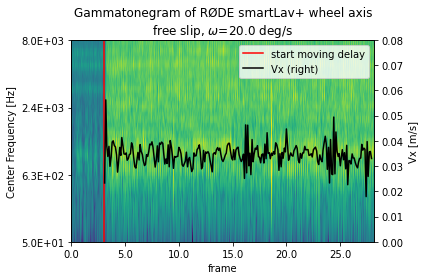

In [14]:
def plot_sample_audio(
    audio_path,
    params: dict,  # Recording parameters
    frame_features: int = 256,
    frame_duration: int = 10,  # [milliseconds]
    # TODO use this to plot some segments and label theme with the average Vx
    segment_frames: int = 100,
    overlap_ratio: float = 0.8,
    show_segments: List[int] = [],
    ax: plt.Axes = None,
    ):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    audio, sample_rate = ao.io.audio_read(audio_path)
    config = ao.io.yaml_load(audio_path.with_suffix('.yaml'))
    ao.plot.gammatonegram(
        audio,
        ax=ax,
        sample_rate=sample_rate,
        frame_samples=int(frame_duration / 1000 * sample_rate),
        num_features=frame_features
        )
    # Show start delay
    ax.axvline(
        params['delay'] / frame_duration,
        color='r',
        label='start moving delay'
        )
    ax.legend()
    # Show Vx
    sample_gt['time'] = (
        sample_gt.index.to_series().diff().cumsum() + params['delay'] / 1000
        )
    sample_gt['frame'] = sample_gt['time'] / frame_duration * 1000
    ax2 = sample_gt.plot(y='Vx', x='frame', ax=ax, secondary_y=True, color='k')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Vx [m/s]')
    ax2.set_ylim(0, 0.08)
    # Show segments
    segment_overlap_frames = int(segment_frames * overlap_ratio)

    # Add title
    ax.set_title(
        f"Gammatonegram of {config['name']}\n"
        f"{'free slip' if np.isnan(params['s']) else 's=' + str(params['s']) }"
        f", $\omega$={params['w']} deg/s"
        )


plot_sample_audio(sample_recording / 'microphone0.wav', recording_parameters)

In [15]:
# TODO plot gammatonegram with the wheeltestbed control Vx

## Experiment 2


In [16]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_2 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-2"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_2)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f"Invalid experiment folder {EXPERIMENT_FOLDER}")
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
DATASETS_FOLDER = EXPERIMENT_FOLDER / 'datasets'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

### Dataset generation

In [17]:
def _generate_dataset(
    recordings: List[Path],
    output_folder: Path,
    frame_features: int,
    frame_duration: int,
    segment_frames: int,
    segment_overlap_frames: int,
    extractors: List[Tuple[Type[ao.extractor.Extractor], dict]],
    wheel_radius: float = 0.1,
    *,
    transform: Optional[Callable[[np.ndarray, dict, pd.DataFrame],
                                 Tuple[np.ndarray, pd.DataFrame]]] = None,
    ):
    """Generates a dataset in WebDataset format given a list of recordings, an
    output folder, a list of feature extractor classes and its initialization
    arguments and some additional parameters that concern the feature
    extraction. The dataset is divided in shards, each shard corresponds to a
    unique device from the recording. Each shard contains a list of segments
    with it's corresponding ground truth oflongitudinal speed, wheel angular
    velocity and slip ratio. Segments can be overlapped. Each segment is
    composed by several frames. A frame is the result of extracting features
    over a determined number of audio samples that are determined by the frame
    duration.

    Args:
        recordings (List[Path]): List of recordings. Each recording is a path
            to a folder containing audio files with corresponding yaml files.
        output_folder (Path): Folder where to save the dataset shards.

        frame_features (int, optional): Number of features per frame.

        frame_duration (int, optional): Number of milliseconds per frame.
            Together with the sample rate, it will define the amount of samples
            used to extract features.
        segment_frames (int, optional): Number of frames per segment.

        segment_overlap_frames (float, optional): Amount of overlap frames
            between segments. 
        extractors (List[Tuple[Type[ao.extractor.Extractor], dict]], optional):
            Pairs of feature extractor classes and their initialization
            arguments. Defaults to [ (ao.extractor.GammatoneFilterbank, {}), ].
        wheel_radius (float, optional): Radius of the wheel in meters. Used in
            order to compute the ground truth slip ratio. Defaults to 0.1.
        transform (Optional[Callable[[np.ndarray, dict, pd.DataFrame],
            Tuple[np.ndarray, pd.DataFrame]]], optional): Callable to be
            applied to the audio signal and the ground truth with the goal of
            augmenting the data. The callable receives as input the audio
            signal array (n_channels x n_samples), the device configuration
            dictionary and the recording ground truth. It must return a tuple
            with the augmented audio signal and its corresponding ground truth.
            Defaults to None. 
    """
    # Progress bars
    progress = {
        'recording':
            tqdm(total=len(recordings), desc='Recordings', unit='folder'),
        'file':
            tqdm(desc='microphone?', unit='file'),
        'segment':
            tqdm(
                desc='Write segments',
                unit='segments',
                bar_format='{desc}: {bar}{r_bar}'
                ),
        'features':
            tqdm(
                desc='Extract features',
                unit='frames',
                bar_format='{desc}: {bar}{r_bar}'
                ),
        }
    # Initialize variables used in the loop
    transform_name = slugify(transform.__name__) if transform else 'None'
    segment_duration = segment_frames * frame_duration
    segment_overlap_duration = segment_overlap_frames * frame_duration
    extractors_by_sample_rate = {}  # {sample_rate: [extractor, ...]}
    writers_by_device = {}  # {config['name']: (ShardWriter, config)}
    csv_file = open(output_folder / f"transform_{transform_name}.csv", 'w')
    csv_writer = csv.DictWriter(
        csv_file,
        fieldnames=['device', 'recording', 'segment', 'Vx', 'Vw', 'slip']
        )
    csv_writer.writeheader()
    # Iterate over recording folders
    try:
        for r_idx, recording in enumerate(recordings):
            # Wheel test bed control data
            try:
                ground_truth = get_recording_ground_truth(
                    recording, wheel_radius=0.10
                    )
            except FileNotFoundError:
                warn(
                    "Skip: No control data found for recording " +
                    recording.name
                    )
                continue
            # Iterate over audio recordings
            wav_files = list(recording.glob('microphone*.wav'))
            progress['file'].reset(len(wav_files))
            for wav_file in wav_files:
                # Read data
                progress['file'].set_description(wav_file.name)
                wav_data, sample_rate = ao.io.audio_read(wav_file)
                config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
                if transform:
                    # ! Transform can mutate `ground_truth`
                    wav_data, wav_gt = transform(
                        wav_data, config, ground_truth
                        )
                else:
                    wav_gt = ground_truth
                if sample_rate != config['samplerate']:
                    warn(f"Skip: Sample rate mismatch for {wav_file.name}")
                    continue
                # Get corresponding extractors
                try:
                    _extractors = extractors_by_sample_rate[sample_rate]
                except KeyError:
                    _extractors = extractors_by_sample_rate[sample_rate] = [
                        _class(
                            num_samples=int(
                                frame_duration * sample_rate / 1000
                                ),
                            num_features=frame_features,
                            sample_rate=sample_rate,
                            **_kwargs
                            ) for _class, _kwargs in extractors
                        ]
                # Get corresponding writer
                device_name = slugify(config['name'])
                try:
                    writer, device_config = writers_by_device[device_name]
                    # Check that the device configuration is the same. File
                    # configuration has `start_timestamp`, `end_timestamp` and
                    # `index` apart from the device configuration.
                    if not device_config.items() <= config.items():
                        warn(
                            f"Configuration mismatch for {wav_file.name}:"
                            f"\nExpected {device_config}\nGot {config}"
                            )
                except KeyError:
                    writer = wds.ShardWriter(
                        str(
                            output_folder /
                            f"transform_{transform_name};device_{device_name};"
                            "shard_%03d.tar"
                            )
                        )
                    device_config = {
                        k: v
                        for k, v in config.items()
                        if 'timestamp' not in k and 'index' not in k
                        }
                    writers_by_device[device_name] = (writer, device_config)
                    ao.io.yaml_dump(
                        device_config,
                        output_folder / f"device_{device_name}.yaml"
                        )
                progress['features'].reset(total=1)
                # Process all features: shape=(channels x features x frames)
                features = ao.dataset.audio.features(wav_data, _extractors)
                n_frames = features.shape[2]
                # Small trick to obtain the metric of frames per second
                progress['features'].total = n_frames
                progress['features'].update(n_frames)
                # Generate overlapped segments from the features
                step = segment_frames - segment_overlap_frames
                num_segments = int((n_frames - segment_frames) / step)
                segments = [
                    features[:, :, n * step:n * step + segment_frames]
                    for n in range(num_segments)
                    ]
                # ! There is a weird time difference here
                start = config['start_timestamp']
                progress['segment'].reset(total=len(segments))
                for idx, segment in enumerate(segments):
                    end = start + segment_duration / 1000
                    result = {
                        var: get_weighted_average(wav_gt, var, start, end)
                        for var in ['Vx', 'Vw', 'slip']
                        }
                    segment_details = {
                        'device': device_name,
                        'recording': r_idx,
                        'segment': idx,
                        **result
                        }
                    writer.write({
                        '__key__':
                            f"transform_{transform_name};device_{device_name};"
                            f"recording_{r_idx};segment_{idx}",
                        'npy': segment,
                        'json': result,
                        })
                    csv_writer.writerow(segment_details)
                    start = end - segment_overlap_duration / 1000
                progress['segment'].update(len(segments))
                progress['file'].update()
            progress['recording'].update()
    finally:
        csv_file.close()
        for writer, _ in writers_by_device.values():
            writer.close()
        for progress_bar in progress.values():
            progress_bar.close()
    return output_folder

In [18]:
def generate_dataset(
    recordings: List[Path],
    name: str,
    frame_features: int = 256,
    frame_duration: int = 10,
    segment_frames: int = 100,
    overlap_ratio: float = 0.8,
    wheel_radius: float = 0.1,
    *,
    datasets_folder: Path = DATASETS_FOLDER,
    extractors: List[Tuple[Type[ao.extractor.Extractor], dict]] = [
        (ao.extractor.GammatoneFilterbank, {}),
        ],
    ) -> Path:
    """Uses the `_generate_dataset` function to generate a dataset a dataset
    without any data augmentation.

    Args:
        recordings (List[Path]): List of recordings. Each recording is a path
            to a folder containing audio files with corresponding yaml files.
        name (str): Name of the dataset. If datasets_folder contains a
            subfolder with the same name, the dataset won't be created.
        frame_features (int, optional): Number of features per frame. Defaults
            to 256.
        frame_duration (int, optional): Number of milliseconds per frame.
            Defaults to 10. Together with the sample rate, it will define the
            amount of samples used to extract features.
        segment_frames (int, optional): Number of frames per segment.
            Defaults to 100.
        overlap_ratio (float, optional): Ratio of overlap between segments.
            Defaults to 0.8. 
        wheel_radius (float, optional): Radius of the wheel in meters. Used in
            order to compute the ground truth slip ratio. Defaults to 0.1.
        datasets_folder (Path, optional): Folder where to write the datasets.
            Defaults to DATASETS_FOLDER. 
        extractors (List[Tuple[Type[ao.extractor.Extractor], dict]], optional):
            Pairs of feature extractor classes and their initialization
            arguments. Defaults to [ (ao.extractor.GammatoneFilterbank, {}), ].

    Raises:
        ValueError: If datasets_folder is not a valid folder. Or if extractor
            initialization arguments contain a lambda function.

    Returns:
        Path: Path to the written dataset under datasets_folder.
    """
    # Check input
    if not datasets_folder.is_dir():
        raise ValueError(
            f"datasets_folder must be a directory, not {datasets_folder}"
            )
    output_folder = Path(datasets_folder) / name
    output_folder.mkdir(exist_ok=True, parents=True)
    # Check if the output folder has already a dataset
    if any(output_folder.glob('transform_None;*.tar')):
        warn(f"Dataset already exists at {output_folder}")
        return output_folder
    # Save dataset generation data in yaml file inside output folder
    segment_overlap_frames = int(segment_frames * overlap_ratio)
    extractors_dict = {}
    for i, (extractor_class, kwargs) in enumerate(extractors):
        _kwargs = {}
        for k, v in kwargs.items():
            if callable(v):
                if v.__name__ == 'lambda':
                    raise ValueError(
                        f"`{k}` can't be a lambda function, because it is "
                        "difficult to parse the source code of a lambda "
                        f"function: {getsource(v)}"
                        )
                _kwargs[k] = getsource(v)
            else:
                _kwargs[k] = v
        extractors_dict[i] = (extractor_class.__name__, _kwargs)
    ao.io.yaml_dump(
        {
            'recordings': [r.name for r in recordings],
            'frame_features': frame_features,
            'frame_duration': frame_duration,
            'segment_frames': segment_frames,
            'overlap_ratio': overlap_ratio,
            'segment_overlap_frames': segment_overlap_frames,
            'extractors': {
                i: [
                    e.__name__,
                    {
                        k: getsource(v) if callable(v) else v
                        for k, v in kwargs.items()
                        }
                    ]
                for i, (e, kwargs) in enumerate(extractors)
                },
            'wheel_radius': wheel_radius,
            'transform': None,
            },
        to_file=output_folder / "transform_None.yaml",
        )
    _generate_dataset(
        recordings=recordings,
        output_folder=output_folder,
        frame_features=frame_features,
        frame_duration=frame_duration,
        segment_frames=segment_frames,
        segment_overlap_frames=segment_overlap_frames,
        extractors=extractors,
        transform=None,
        )
    return output_folder


def do_nothing(features: np.ndarray) -> np.ndarray:
    return features


dataset_path = generate_dataset(
    list(recordings.keys())[0:1],
    'test',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=100,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': do_nothing,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )

C:\Users\esdan\AppData\Local\Temp\ipykernel_18116\672985231.py:56: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test
  warn(f"Dataset already exists at {output_folder}")


### Visualization

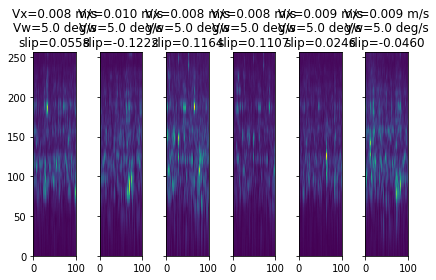

In [19]:
def show_dataset_samples(
    dataset_path: Path,
    shard_filter: Callable[[dict], bool] = lambda params: True,
    samples: int = 6,
    shuffle: int = 10E6,
    ):
    shards = [
        s for s in dataset_path.glob('*.tar')
        if shard_filter(ao.dataset.parse_filename(s.stem))
        ]
    if not shards:
        raise ValueError(
            f"No shards found in {dataset_path} with filter {shard_filter}"
            )
    dataset = wds.DataPipeline(
        wds.SimpleShardList([f"file:{path}" for path in shards]),
        wds.tarfile_to_samples(),
        wds.decode(
            wds.handle_extension('.npy', lambda x: np.load(io.BytesIO(x)))
            ),
        wds.to_tuple('npy', 'json'),
        wds.shuffle(shuffle),
        )
    # Get dataset config
    config = {}
    for config_file in dataset_path.glob('*.yaml'):
        file_params = ao.dataset.parse_filename(config_file.stem)
        key = next(iter(file_params))
        config.setdefault(key, {}).update({
            file_params[key]: ao.io.yaml_load(config_file)
            })
    # Plot random samples
    num_extractors = len(config['transform']['None']['extractors'])
    _, axs = plt.subplots(
        num_extractors, samples, squeeze=False, sharex=True, sharey=True
        )
    iter_dataset = iter(dataset)
    for col in range(samples):
        features, result = next(iter_dataset)
        for row in range(num_extractors):
            axs[row][col].pcolormesh(features[row, :, :], shading='flat')
        axs[0][col].set_title(
            f"Vx={result['Vx']:0.3f} m/s\n"
            f"Vw={result['Vw']:0.1f} deg/s\n"
            f"slip={result['slip']:0.4f}"
            )
    # TODO plot Vx histogram
    # TODO plot Vw vs slip histogram


show_dataset_samples(
    dataset_path, shard_filter=lambda d: d['device'] == 'rode-smartlav-top'
    )

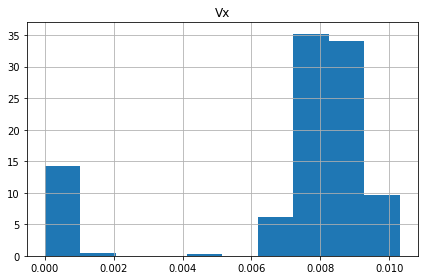

In [20]:
def show_dataset_details(
    dataset_path: Path,
    shard_filter: Callable[[dict], bool] = lambda params: True,
    ):
    # Plot Vx histogram
    # TODO for csv in dataset_path.glob('*.csv'):
    df = pd.read_csv(dataset_path / 'transform_None.csv')
    df.hist(column='Vx', weights=np.ones_like(df.index) * 100 / len(df.index))
    # TODO plot Vw vs slip histogram


show_dataset_details(dataset_path)

In [21]:
def show_dataset(
    dataset_path,
    shard_filter: Callable[[dict], bool] = lambda params: True,
    ):
    # TODO create a figure with subfigures
    show_dataset_samples(dataset_path, shard_filter)
    show_dataset_details(dataset_path, shard_filter)

### Data agumentation

C:\Users\esdan\AppData\Local\Temp\ipykernel_18116\4123382239.py:41: UserWarning: Augmented dataset `nope` already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test
  warn(f"Augmented dataset `{name}` already exists at {dataset_path}")


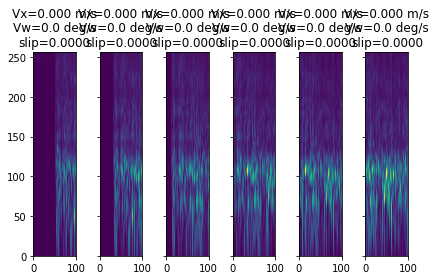

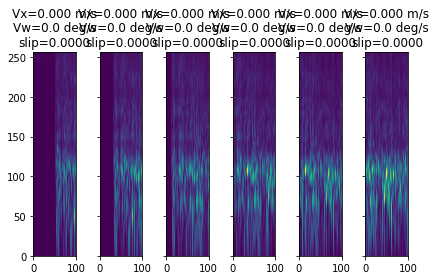

In [22]:
def augment_dataset(
    dataset_path: Path,
    data_folder: Path = DATA_FOLDER,
    transform: Optional[Callable[[np.ndarray, dict, pd.DataFrame],
                                 Tuple[np.ndarray, pd.DataFrame]]] = None,
    ):
    """Applies a given transform function to a dataset. Feature
    extraction parameters will be taken from the dataset config file.

    Args:
        dataset_path (Path): Path to the dataset to augment.

        data_folder (Path, optional): Path to the folder where to find the
            recordings used in the dataset that should be augmented. Defaults
            to DATA_FOLDER.
        transform (Optional[Callable[[np.ndarray, dict, pd.DataFrame],
            Tuple[np.ndarray, pd.DataFrame]]], optional): Callable to be
            applied to the audio signal and the ground truth with the goal of
            augmenting the data. The callable receives as input the audio
            signal array (n_channels x n_samples), the device configuration
            dictionary and the recording ground truth. It must return a tuple
            with the augmented audio signal and its corresponding ground truth.
            Defaults to None. 

    Raises:
        ValueError: If the transform function is a lambda function.
        RuntimeError: If a recording from the dataset configuration can't be
            found in the provided data folder.
        RuntimeError: If an extractor specified in the dataset configuration
            can't be found int the available extractors.
    """
    name = slugify(transform.__name__)
    if name == 'lambda':
        raise ValueError(
            "`transform` can't be a lambda function, because it is difficult "
            "to parse the source code of a lambda function: "
            f"{getsource(transform)}"
            )
    # Check if the output folder has already a dataset
    if any(dataset_path.glob(f"transform_{name};*.tar")):
        warn(f"Augmented dataset `{name}` already exists at {dataset_path}")
        return
    # Get dataset configuration
    config = ao.io.yaml_load(dataset_path / "transform_None.yaml")
    # Build dataset generation input from dataset configuration
    recordings = []
    for recording_name in config['recordings']:
        recording = data_folder / recording_name
        if not recording.is_dir():
            raise RuntimeError(
                f"Recording {recording_name} not found in {data_folder}"
                )
        recordings.append(recording)
    extractors = []
    for (extractor_name, extractor_kwargs) in config['extractors'].values():
        try:
            extractor_class = getattr(ao.extractor, extractor_name)
        except AttributeError as e:
            raise RuntimeError(f"Extractor `{extractor_name}` not found: {e}")
        # Do not modify the original extractor_kwargs
        _kwargs = {}
        for k, v in extractor_kwargs.items():
            if isinstance(v, str):
                match = re.search(r"def (?P<function_name>.*)\(", v)
                if match:
                    # ! This code is unsafe, it could be tricked by a
                    # ! maliciously built config file
                    exec(v)
                    _kwargs[k] = eval(match.group('function_name'))
                    continue
            _kwargs[k] = v
        extractors.append((extractor_class, _kwargs))
    # Save augmented dataset configuration
    config['transform'] = getsource(transform)
    ao.io.yaml_dump(config, dataset_path / f"transform_{name}.yaml")
    _generate_dataset(
        recordings=recordings,
        output_folder=dataset_path,
        frame_features=config['frame_features'],
        frame_duration=config['frame_duration'],
        segment_frames=config['segment_frames'],
        segment_overlap_frames=config['segment_overlap_frames'],
        extractors=extractors,
        wheel_radius=config['wheel_radius'],
        transform=transform,
        )


def nope(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    return audio, ground_truth


augment_dataset(dataset_path, transform=nope)
for name in ['None', 'nope']:
    show_dataset_samples(
        dataset_path, shard_filter=lambda d: d['transform'] == name, shuffle=0
        )

C:\Users\esdan\AppData\Local\Temp\ipykernel_18116\4123382239.py:41: UserWarning: Augmented dataset `noise-snr-01` already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\test
  warn(f"Augmented dataset `{name}` already exists at {dataset_path}")


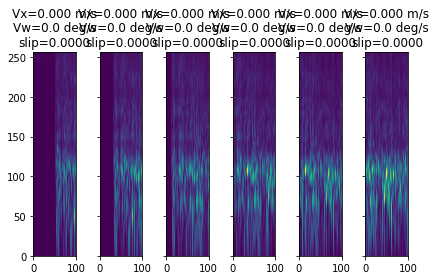

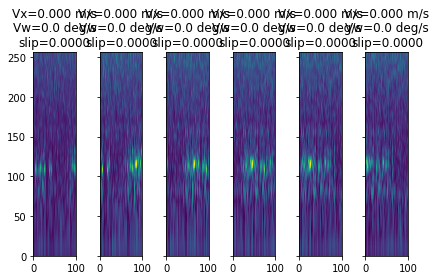

In [23]:
def noise_snr_01(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    snr = 0.1
    # https://github.com/SuperKogito/pydiogment/blob/074543dc9483b450653f8a00c8279bf1eb873199/pydiogment/auga.py#L36
    # ! Important to keep the float64 type of audio
    noise = np.random.rand(*audio.shape).astype(np.float64)
    # compute powers
    noise_power = np.mean(np.power(noise, 2))
    audio_power = np.mean(np.power(audio, 2))
    # compute snr and scaling factor
    snr_linear = 10**(snr / 10.0)
    noise_factor = (audio_power / noise_power) * (1 / snr_linear)
    # add noise
    # ! Important in place operation in order to keep the memory layout.
    # ! Extractor only works with one memory layout at the moment.
    audio += np.sqrt(noise_factor) * noise
    return audio, ground_truth


augment_dataset(dataset_path, transform=noise_snr_01)

# TODO format in a single plot for the report
for name in ['None', 'noise-snr-01']:
    show_dataset_samples(
        dataset_path, shard_filter=lambda d: d['transform'] == name, shuffle=0
        )


## Subset a dataset

C:\Users\esdan\AppData\Local\Temp\ipykernel_18116\78469792.py:11: UserWarning: Dataset `_test` already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\_test
  warn(f"Dataset `{name}` already exists at {dst_dataset_path}")


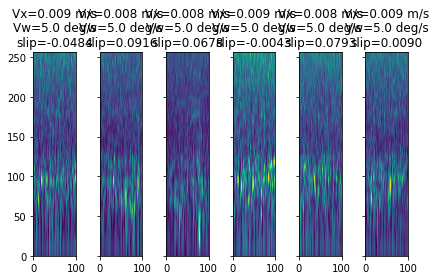

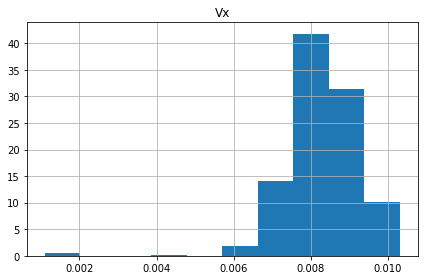

In [30]:
def subset_dataset(
    source_dataset_path,
    name: str,
    sample_filter: Callable[[dict], bool],
    # TODO shard_filter
    datasets_folder: Path = DATASETS_FOLDER,
    ) -> Path:
    dst_dataset_path = datasets_folder / name
    try:
        dst_dataset_path.mkdir()
    except FileExistsError:
        warn(f"Dataset `{name}` already exists at {dst_dataset_path}")
        return dst_dataset_path
    for shard in tqdm(
        sorted(source_dataset_path.glob('*.tar')),
        desc='Shards',
        unit='shards'
        ):
        dataset = wds.DataPipeline(
            wds.SimpleShardList([f"file:{shard}"]),
            wds.tarfile_to_samples(),
            wds.decode(), # Only decodes json
            wds.to_tuple('__key__', 'npy', 'json'),
            )
        new_shard = dst_dataset_path / shard.name
        with wds.TarWriter(f"file:{new_shard}") as writer:
            for key, npy, result in dataset:
                if sample_filter(result):
                    writer.write({
                        '__key__': key,
                        'npy': npy,
                        'json': result,
                        })
    for config_file in source_dataset_path.glob('*.yaml'):
        config = ao.io.yaml_load(config_file)
        ao.io.yaml_dump(config, dst_dataset_path / config_file.name)
    for csv_file in source_dataset_path.glob('*.csv'):
        source = pd.read_csv(csv_file)
        dst = source[source.apply(sample_filter, axis=1)]
        dst.to_csv(dst_dataset_path / csv_file.name)
    return dst_dataset_path


subset_dataset_path = subset_dataset(
    dataset_path, 'test_subset', lambda results: results['Vx'] > 0
    )

show_dataset(subset_dataset_path)


# Datasets


### Feature transforms


In [32]:
def log10(features: np.ndarray) -> np.ndarray:
    return np.log10(features)

### Audio augmentation transforms


In [25]:
def add_random_snr_noise(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    snr = np.random.uniform(0, 1)
    # https://github.com/SuperKogito/pydiogment/blob/074543dc9483b450653f8a00c8279bf1eb873199/pydiogment/auga.py#L36
    # ! Keep the float64 type of audio. Extractor only works with doubles at
    # ! the moment.
    noise = np.random.rand(*audio.shape).astype(np.float64)
    # compute powers
    noise_power = np.mean(np.power(noise, 2))
    audio_power = np.mean(np.power(audio, 2))
    # compute snr and scaling factor
    snr_linear = 10**(snr / 10.0)
    noise_factor = (audio_power / noise_power) * (1 / snr_linear)
    # add noise
    # ! In place operation in order to keep the memory layout. Extractor only
    # ! works with one memory layout at the moment.
    audio += np.sqrt(noise_factor) * noise
    return audio, ground_truth


def add_random_gain(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    raise NotImplementedError()


def normalize(
    audio: np.ndarray,
    device_config: dict,
    ground_truth: pd.DataFrame,
    ) -> Tuple[np.ndarray, pd.DataFrame]:
    raise NotImplementedError()

### Reducers

In [1]:
def reduce_Vx_zeros(results):
    return results['Vx'] > 0.001 or bool(random.randint(0, 1))

## Base


C:\Users\esdan\AppData\Local\Temp\ipykernel_18116\672985231.py:56: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\base
  warn(f"Dataset already exists at {output_folder}")


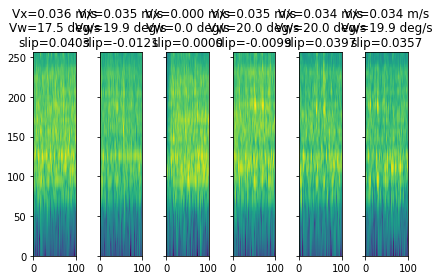

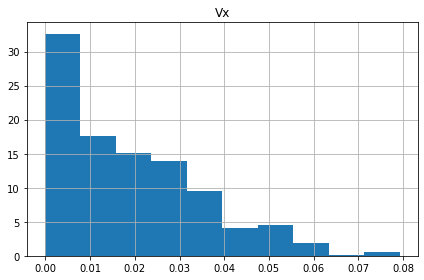

In [33]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'raw-base',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=100,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
# augment_dataset(dataset_path, transform=add_random_snr_noise)
# for name in ['None', 'add-random-snr-noise']:
for name in ['None']:
    show_dataset_samples(
        dataset_path, shard_filter=lambda d: d['transform'] == name
        )

In [ ]:
subset_dataset_path = subset_dataset(
    dataset_path, 'base', sample_filter=reduce_Vx_zeros
    )
show_dataset(subset_dataset_path)

### Longer segment

In [ ]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'raw-segment-120',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=120,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset_samples(dataset_path)

In [ ]:
subset_dataset_path = subset_dataset(
    dataset_path, 'segment-120', sample_filter=reduce_Vx_zeros
    )
show_dataset(subset_dataset_path)

### Reduced overlapping


C:\Users\esdan\AppData\Local\Temp\ipykernel_24544\672985231.py:56: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\overlap-06
  warn(f"Dataset already exists at {output_folder}")


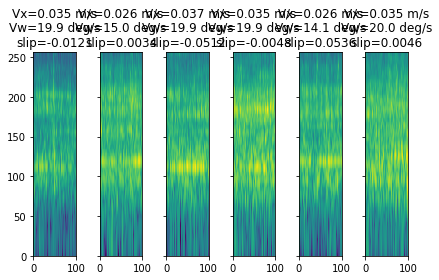

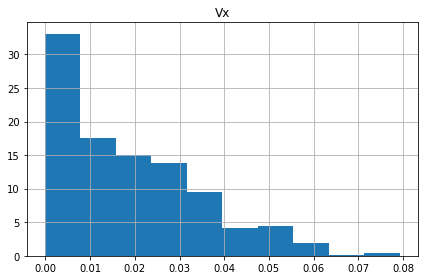

In [30]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'raw-overlap-06',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=100,
    overlap_ratio=0.6,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset_samples(dataset_path)

In [ ]:
subset_dataset_path = subset_dataset(
    dataset_path, 'overlap-06', sample_filter=reduce_Vx_zeros
    )
show_dataset(subset_dataset_path)

### Reduced frame duration


C:\Users\esdan\AppData\Local\Temp\ipykernel_24544\672985231.py:56: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\duration-5
  warn(f"Dataset already exists at {output_folder}")


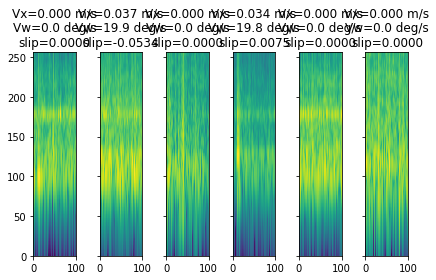

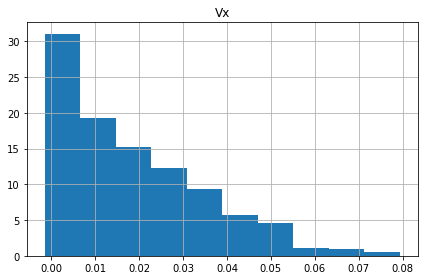

In [31]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'raw-duration-5',
    frame_features=256,
    frame_duration=5,  # [milliseconds]
    segment_frames=100,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset(dataset_path)


In [ ]:
subset_dataset_path = subset_dataset(
    dataset_path, 'duration-05', sample_filter=reduce_Vx_zeros
    )
show_dataset(subset_dataset_path)

### Only positive slip ratios


C:\Users\esdan\AppData\Local\Temp\ipykernel_17728\4071030947.py:53: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\no-negative-slip
  warn(f"Dataset already exists at {output_folder}")


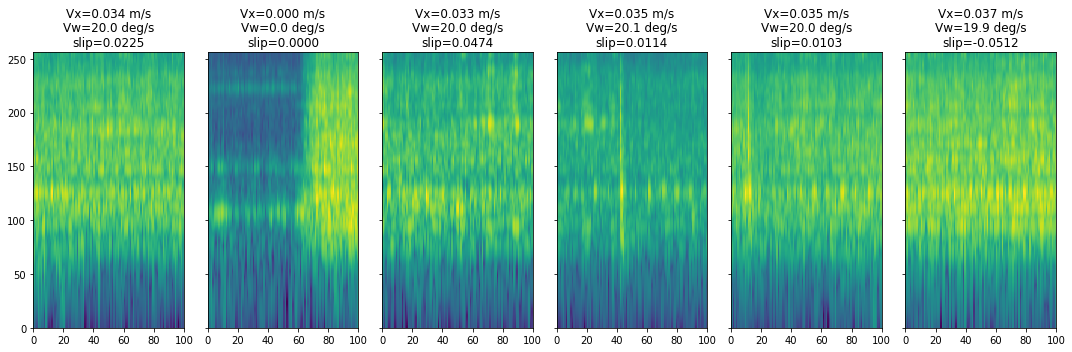

In [51]:
dataset_path = generate_dataset(
    [r for r, d in recordings.items() if np.isnan(d['s']) or d['s'] >= 0],
    'raw-no-negative-slip',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=100,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank,
            {
                'transform': log10,
                'on_channel': -1,  # Average
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset(dataset_path)

In [ ]:
subset_dataset_path = subset_dataset(
    dataset_path, 'no-negative-slip', sample_filter=reduce_Vx_zeros
    )
show_dataset(subset_dataset_path)

## Double channel


C:\Users\esdan\AppData\Local\Temp\ipykernel_17728\4071030947.py:53: UserWarning: Dataset already exists at G:\Shared drives\VAO\VAO_WheelTestBed-Experiment-2\datasets\double-channel
  warn(f"Dataset already exists at {output_folder}")


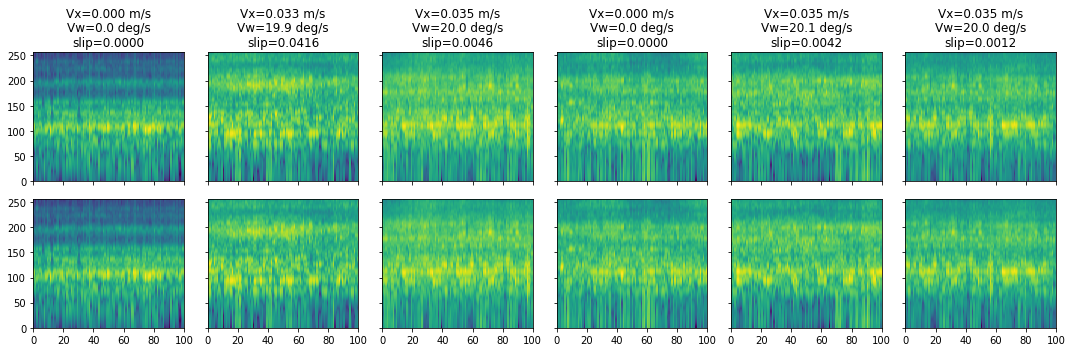

In [54]:
dataset_path = generate_dataset(
    list(recordings.keys()),
    'raw-double-channel',
    frame_features=256,
    frame_duration=10,  # [milliseconds]
    segment_frames=100,
    overlap_ratio=0.8,
    extractors=[
        (
            ao.extractor.GammatoneFilterbank, {
                'transform': log10,
                'on_channel': 0,
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        (
            ao.extractor.GammatoneFilterbank, {
                'transform': log10,
                'on_channel': 1,
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )
show_dataset(dataset_path)

In [ ]:
subset_dataset_path = subset_dataset(
    dataset_path, 'double-channel', sample_filter=reduce_Vx_zeros
    )
show_dataset(subset_dataset_path)